In [8]:
import requests
import pandas as pd

def fetch_transport_data(query, transport_type):
    overpass_url = "https://overpass-api.de/api/interpreter"
    response = requests.post(overpass_url, data={'data': query[transport_type]})
    if response.status_code == 200:
        data = response.json()
        stations_data = []
        for idx, no in enumerate(data['elements'], start=1):
            station_data = {
                'Name': no['tags'].get('name', ''),
                'Latitude': no['lat'],
                'Longitude': no['lon'],
                'Transport_type': transport_type,
                'Route': no['tags'].get('route_ref', '') or no['tags'].get('ref', '')
            }
            stations_data.append(station_data)
        
        df = pd.DataFrame(stations_data)
        return df
    else:
        print(f"Error: {response.status_code}")
        return None


queries = {
    'metro': """[out:json]; area["wikidata"="Q90"]->.search; node(area.search)["railway"="station"]; out;""",
    'bus': """[out:json]; area["wikidata"="Q90"]->.search; node(area.search)["highway"="bus_stop"]; out;""",
    'tram': """[out:json]; area["wikidata"="Q90"]->.search; node(area.search)["railway"="tram_stop"]; out;""",
    'taxi': """[out:json]; area["wikidata"="Q90"]->.search; node(area.search)["amenity"="taxi"]; out;""",
    'velo': """[out:json]; area["wikidata"="Q90"]->.search; node(area.search)["amenity"="bicycle_rental"]; out;"""
}


data = fetch_transport_data(queries, transport_type = 'bus')
# print(data)
data.head()



,Name,Latitude,Longitude,Transport_type,Route
0,Degas,48.848958,2.275412,bus,
1,Musée d'Art Moderne - Palais de Tokyo,48.862974,2.295497,bus,72
2,Les Plantes,48.829561,2.322069,bus,
3,Les Plantes,48.829072,2.323078,bus,
4,Cambronne - Lecourbe,48.842330,2.302803,bus,


In [9]:
# Fetch metro data
metro_data = fetch_transport_data(queries, transport_type='metro')

# Fetch bus data
bus_data = fetch_transport_data(queries, transport_type='bus')

# Combine metro and bus data
combined_data = pd.concat([metro_data, bus_data], ignore_index=True)

# Save the combined data to a CSV file
combined_data.to_csv('paris_metro_bus_data.csv', index=False)

# print(combined_data.head())
# print(f"Total rows: {len(combined_data)}")
combined_data.tail()

,Name,Latitude,Longitude,Transport_type,Route
3058,Porte Maillot - Palais des Congrès,48.877389,2.283102,bus,
3059,Porte Maillot - Palais des Congrès,48.877709,2.283200,bus,
3060,Kléber - Boissière,48.866624,2.290412,bus,30
3061,,48.849546,2.388705,bus,
3062,Place de la Chapelle,48.885055,2.359289,bus,38;N43


In [11]:
# pip install openrouteservice


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree

# Load the datasets
metro_bus_df = pd.read_csv('paris_metro_bus_data.csv')
listings_df = pd.read_csv('cleaned_listings_another.csv')

# Function to find nearest transport points
def find_nearest_transport(listings, transport, k=5):
    transport_tree = cKDTree(transport[['Longitude', 'Latitude']])
    distances, indices = transport_tree.query(listings[['longitude', 'latitude']], k=k)
    
    for i in range(k):
        listings[f'nearest_transport_{i+1}'] = transport.iloc[indices[:, i]]['Name'].values
        listings[f'nearest_transport_{i+1}_type'] = transport.iloc[indices[:, i]]['Transport_type'].values
        listings[f'distance_to_transport_{i+1}'] = distances[:, i]
    
    return listings

# Find nearest transport points for each listing
combined_df = find_nearest_transport(listings_df, metro_bus_df)

# Display the first few rows of the combined dataset
# print(combined_df.head())

# Save the combined dataset
combined_df.to_csv('listings_with_transport.csv', index=False)
combined_df.head()

,id,name,host_id,host_name,host_since,host_is_superhost,neighbourhood,latitude,longitude,property_type,...,distance_to_transport_2,nearest_transport_3,nearest_transport_3_type,distance_to_transport_3,nearest_transport_4,nearest_transport_4_type,distance_to_transport_4,nearest_transport_5,nearest_transport_5_type,distance_to_transport_5
0,80260,Nice studio in Jourdain's village,333548,Charlotte,2011-01-03,f,NaN,48.87131,2.38848,Entire rental unit,...,0.002645,Henri Chevreau,bus,0.002803,Henri Chevreau,bus,0.002891,Pyrénées - Belleville,bus,0.003143
1,3109,zen and calm,3631,Anne,2008-10-14,f,Neighborhood highlights,48.83191,2.31870,Entire rental unit,...,0.001283,Alésia - Didot,bus,0.001437,Pernety,bus,0.001941,Pernety,bus,0.002044
2,80301,toits de Paris,433758,Genevieve,2011-03-10,t,Neighborhood highlights,48.83918,2.34699,Private room in rental unit,...,0.001288,Port Royal - Berthollet,bus,0.001837,Port Royal - Berthollet,bus,0.001997,Berthollet - Vauquelin,bus,0.002140
3,5396,Your perfect Paris studio on Île Saint-Louis,7903,Borzou,2009-02-14,f,Neighborhood highlights,48.85247,2.35835,Entire rental unit,...,0.002156,Pont Marie,metro,0.002198,Pont Sully - Quai de Béthune,bus,0.002396,Pont de Sully - Île Saint Louis,bus,0.002602
4,7397,MARAIS - 2ROOMS APT - 2/4 PEOPLE,2626,Franck,2008-08-30,t,NaN,48.85909,2.35315,Entire rental unit,...,0.001865,La Verrerie,bus,0.001975,Centre Georges Pompidou,bus,0.002099,Hôtel de Ville,metro,0.002235


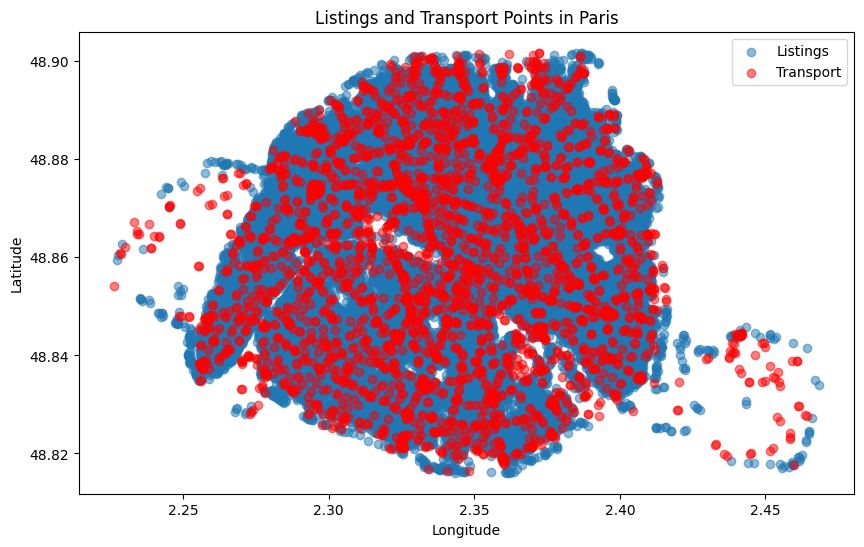

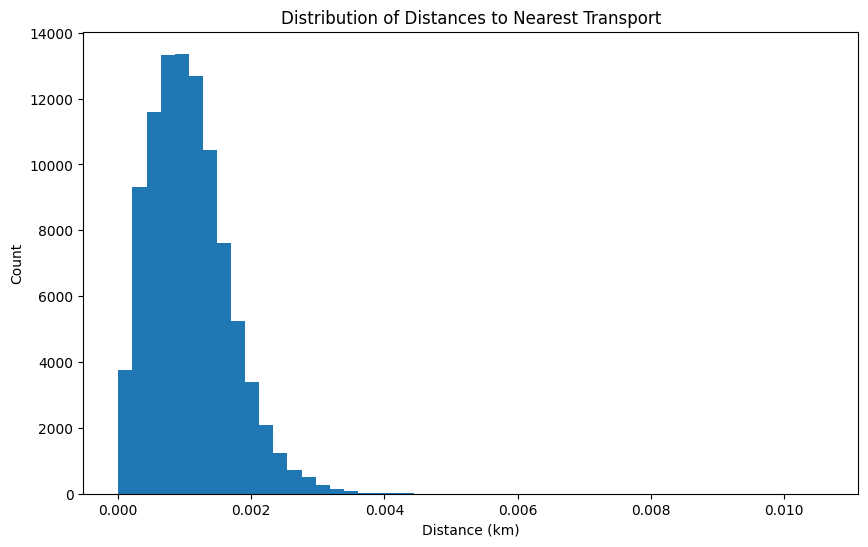

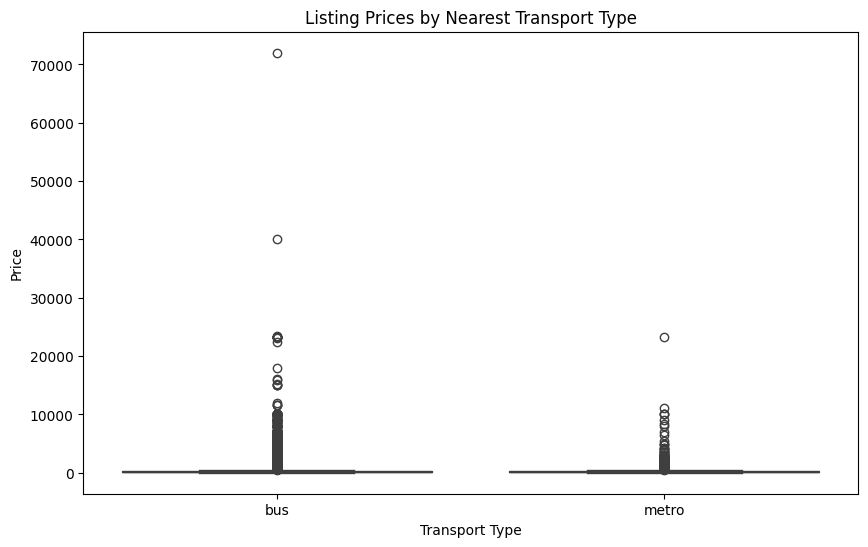

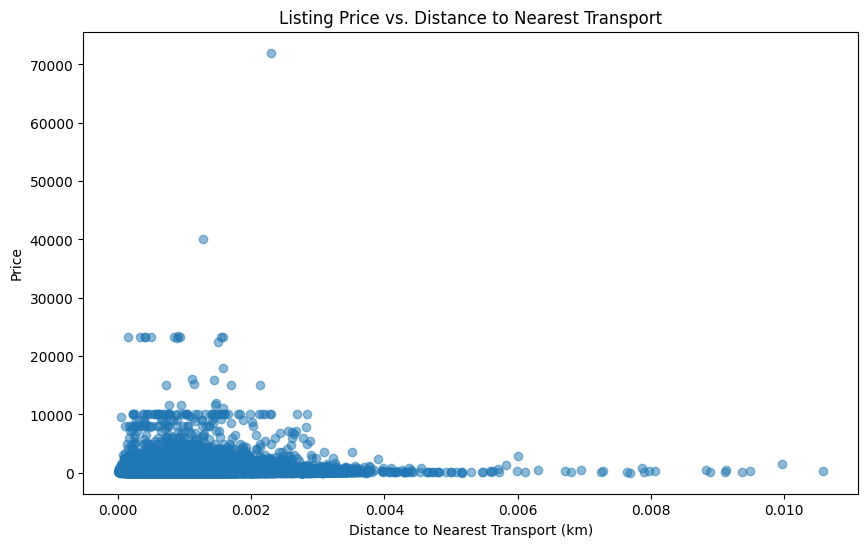

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load the combined data
df = pd.read_csv('listings_with_transport.csv')

# 1. Scatter plot of listings and transport points
plt.figure(figsize=(10, 6))
plt.scatter(df['longitude'], df['latitude'], alpha=0.5, label='Listings')
plt.scatter(metro_bus_df['Longitude'], metro_bus_df['Latitude'], c='red', alpha=0.5, label='Transport')
plt.title('Listings and Transport Points in Paris')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

# 2. Histogram of distances to nearest transport
plt.figure(figsize=(10, 6))
plt.hist(df['distance_to_transport_1'], bins=50)
plt.title('Distribution of Distances to Nearest Transport')
plt.xlabel('Distance (km)')
plt.ylabel('Count')
plt.show()

# 3. Box plot of listing prices by nearest transport type
plt.figure(figsize=(10, 6))
sns.boxplot(x='nearest_transport_1_type', y='price', data=df)
plt.title('Listing Prices by Nearest Transport Type')
plt.xlabel('Transport Type')
plt.ylabel('Price')
plt.show()

# 4. Scatter plot of listing price vs. distance to nearest transport
plt.figure(figsize=(10, 6))
plt.scatter(df['distance_to_transport_1'], df['price'], alpha=0.5)
plt.title('Listing Price vs. Distance to Nearest Transport')
plt.xlabel('Distance to Nearest Transport (km)')
plt.ylabel('Price')
plt.show()

# 5. Heatmap of correlation between numeric variables
numeric_columns = ['price', 'distance_to_transport_1', 'distance_to_transport_2', 'distance_to_transport_3', 'distance_to_transport_4', 'distance_to_transport_5']
correlation_matrix = df[numeric_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

print("Visualizations have been saved as PNG files.")

In [16]:
combined_df.columns.to_numpy().tolist()

['id',
 'name',
 'host_id',
 'host_name',
 'host_since',
 'host_is_superhost',
 'neighbourhood',
 'latitude',
 'longitude',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms_text',
 'bedrooms',
 'beds',
 'amenities',
 'price',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'instant_bookable',
 'bathrooms',
 'host_experience',
 'amenities_count',
 'nearest_transport_1',
 'nearest_transport_1_type',
 'distance_to_transport_1',
 'nearest_transport_2',
 'nearest_transport_2_type',
 'distance_to_transport_2',
 'nearest_transport_3',
 'nearest_transport_3_type',
 'distance_to_transport_3',
 'nearest_transport_4',
 'nearest_transport_4_type',
 'distance_to_transport_4',
 'nearest_transport_5',
 'nearest_transport_5_type',
 'distance_to_transport_5']